In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import IDR_utils
import os
import numpy as np
from stardist import random_label_cmap, _draw_polygons
lbl_cmap = random_label_cmap()
from stardist.models import StarDist2D
from glob import glob
import multiprocessing as mp
import ImportImg
from im_ClearBorder import im_ClearBorder
from im_segment import im_segment
import cv2

Using TensorFlow backend.


# Obtaining the source images

#### Define the compound and Channel of interest.
#### Define the path of the source images

In [101]:
# Getting a list of image paths and ground truths by consulting the IDR database

CompoundsOfInterest=['DMSO']
ChannelsOfInterest=['Hoechst'] 
# ChannelsOfInterest=['Hoechst', 'ERSyto', 'ERSytoBleed', 'Ph_golgi', 'Mito']

# Local source of images or path where images will be downloaded
Local_ImgPath = os.path.abspath(r'\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\RawImages')

# idx_file = None # Use None to download the idx_file from IDR's github
idx_file = './idr0016-screenA-annotation.csv'

# Checking which all files have to be downloaded
Targets, dwnld_args = IDR_utils.IDR_ImgAvailChk(CompoundsOfInterest, ChannelsOfInterest, Local_ImgPath, idx_file)

No. of targets identified =  27070
No. of files to be downloaded =  389


In [102]:
Downld_missing_files = False
if Downld_missing_files:
    IDR_utils.IDR_ImageFetcher (dwnld_args)
else:
    plates2remove=[(os.path.basename(arg[0]))[0:5] for arg in dwnld_args]
    Targets=[Target for Target in Targets if Target['Plate'] not in plates2remove]

#### Define the destination of the segmented images

In [103]:
assert len(ChannelsOfInterest) == 1, "ChannelsOfInterest should contain only one value prior to segmentation"
assert len(CompoundsOfInterest) == 1, "CompoundsOfInterest should contain only one value prior to segmentation"

SaveDir_of_SegmentedImg=os.path.abspath(os.path.join(r'\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented',CompoundsOfInterest[0]))   

# Checking is these images have already been segmented before and updating the list of images accordingly
TargetPlates=np.unique([Target['Plate'] for Target in Targets])
ExistingPlates=np.unique([name[0:5] for name in os.listdir(SaveDir_of_SegmentedImg)])
TargetPlates=[TargetPlate for TargetPlate in TargetPlates if TargetPlate not in ExistingPlates]
Targets=[Target for Target in Targets if Target['Plate'] in TargetPlates]


C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [104]:
# Generating list of files to be imported for segmentation
SourcePaths = []
ImportDetails = []  # will be useful for naming crops later
for Target in Targets:
    source_folder = os.path.abspath(os.path.join(Local_ImgPath,f"{Target['Plate']}-{ChannelsOfInterest[0]}"))
    Well = Target['Well'].lower()
    if len(Well)<3:
        Well = str(Well[0]+'0'+Well[1])
    Well = str('_'+Well+'_')
    files = [file for file in os.listdir(source_folder) if Well in file]
    for file in files:
        SourcePaths.append(os.path.abspath(os.path.join(source_folder,file))) 
        ImportDetails.append({'Plate':Target['Plate'], 'Well':Well, 'File':file, 'Compound Name':Target['Compound Name']})
        
print('No. of files to be segmented = ', str(len(SourcePaths)))

No. of files to be segmented =  9264


In [105]:
# Clearing memory
del Targets, TargetPlates, ExistingPlates, plates2remove, dwnld_args, source_folder, Well, files, file

# StarDist

No. of files to be segmented =  9264

1st file_path :
 \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\RawImages\24294-Hoechst\cdp2bioactives_a13_s3_w14f4dc5b5-b960-4345-998d-8813a416fbce.tif

Destination path of segmented images :
 \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented\DMSO


Text(0.5, 1.0, 'Source image')

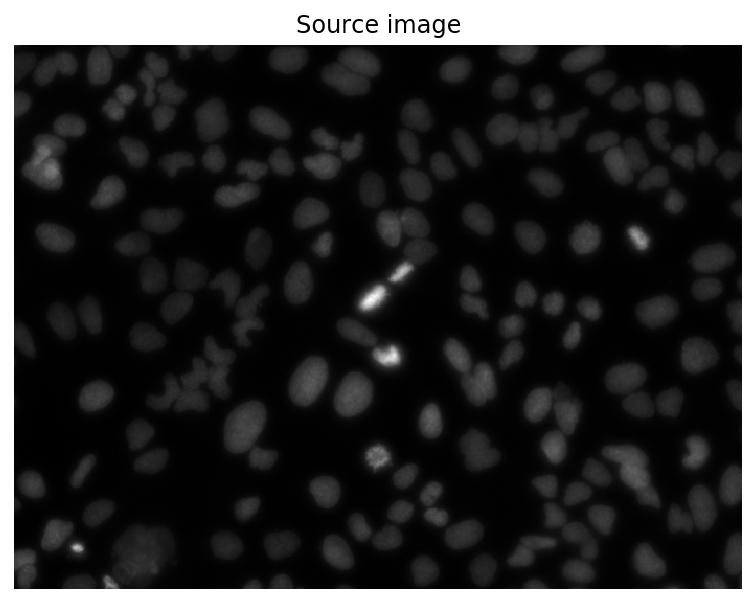

In [23]:
X_Paths = SourcePaths
Segmented_dir = SaveDir_of_SegmentedImg
print('No. of files to be segmented = ', str(len(SourcePaths)))
print('\n1st file_path :\n', X_Paths[0])
print('\nDestination path of segmented images :\n', Segmented_dir)

with mp.Pool() as pool:
    X = pool.map(ImportImg.Import_GrayImg,[path for path in X_Paths])

plt.figure(figsize=(8,5))
plt.imshow(X[0],cmap='gray', norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Source image')


In [37]:
# Clearing memory
del X_Paths, SourcePaths

NameError: name 'X_Paths' is not defined

# Defining weights to load

In [7]:
Use_custom_model = True

if Use_custom_model:
    ModelDir = os.path.abspath(r'\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\StarDist_Segmentation')
    ModelName = 'stardist'
    # Not used if Use_custom_model is set to flase. 
    # The in-built 2D_versatile_fluo weights is then used
    
    model = StarDist2D(None, name=ModelName, basedir=ModelDir)
    print('\nLoaded custom weights save in :\n',str(os.path.join(ModelDir,ModelName)))
else:
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
    print("\nLoaded pretrained weights from in-built '2D_versatile_fluo'")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.768265, nms_thresh=0.3.

Loaded custom weights save in :
 \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\StarDist_Segmentation\stardist


# Prediction
Make sure the input images are normalized before passing to the model.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [11]:
# label, detail = model.predict_instances(x)

predictions = [model.predict_instances(x) for x in X]
Labels ,details = map(list,zip(*predictions))


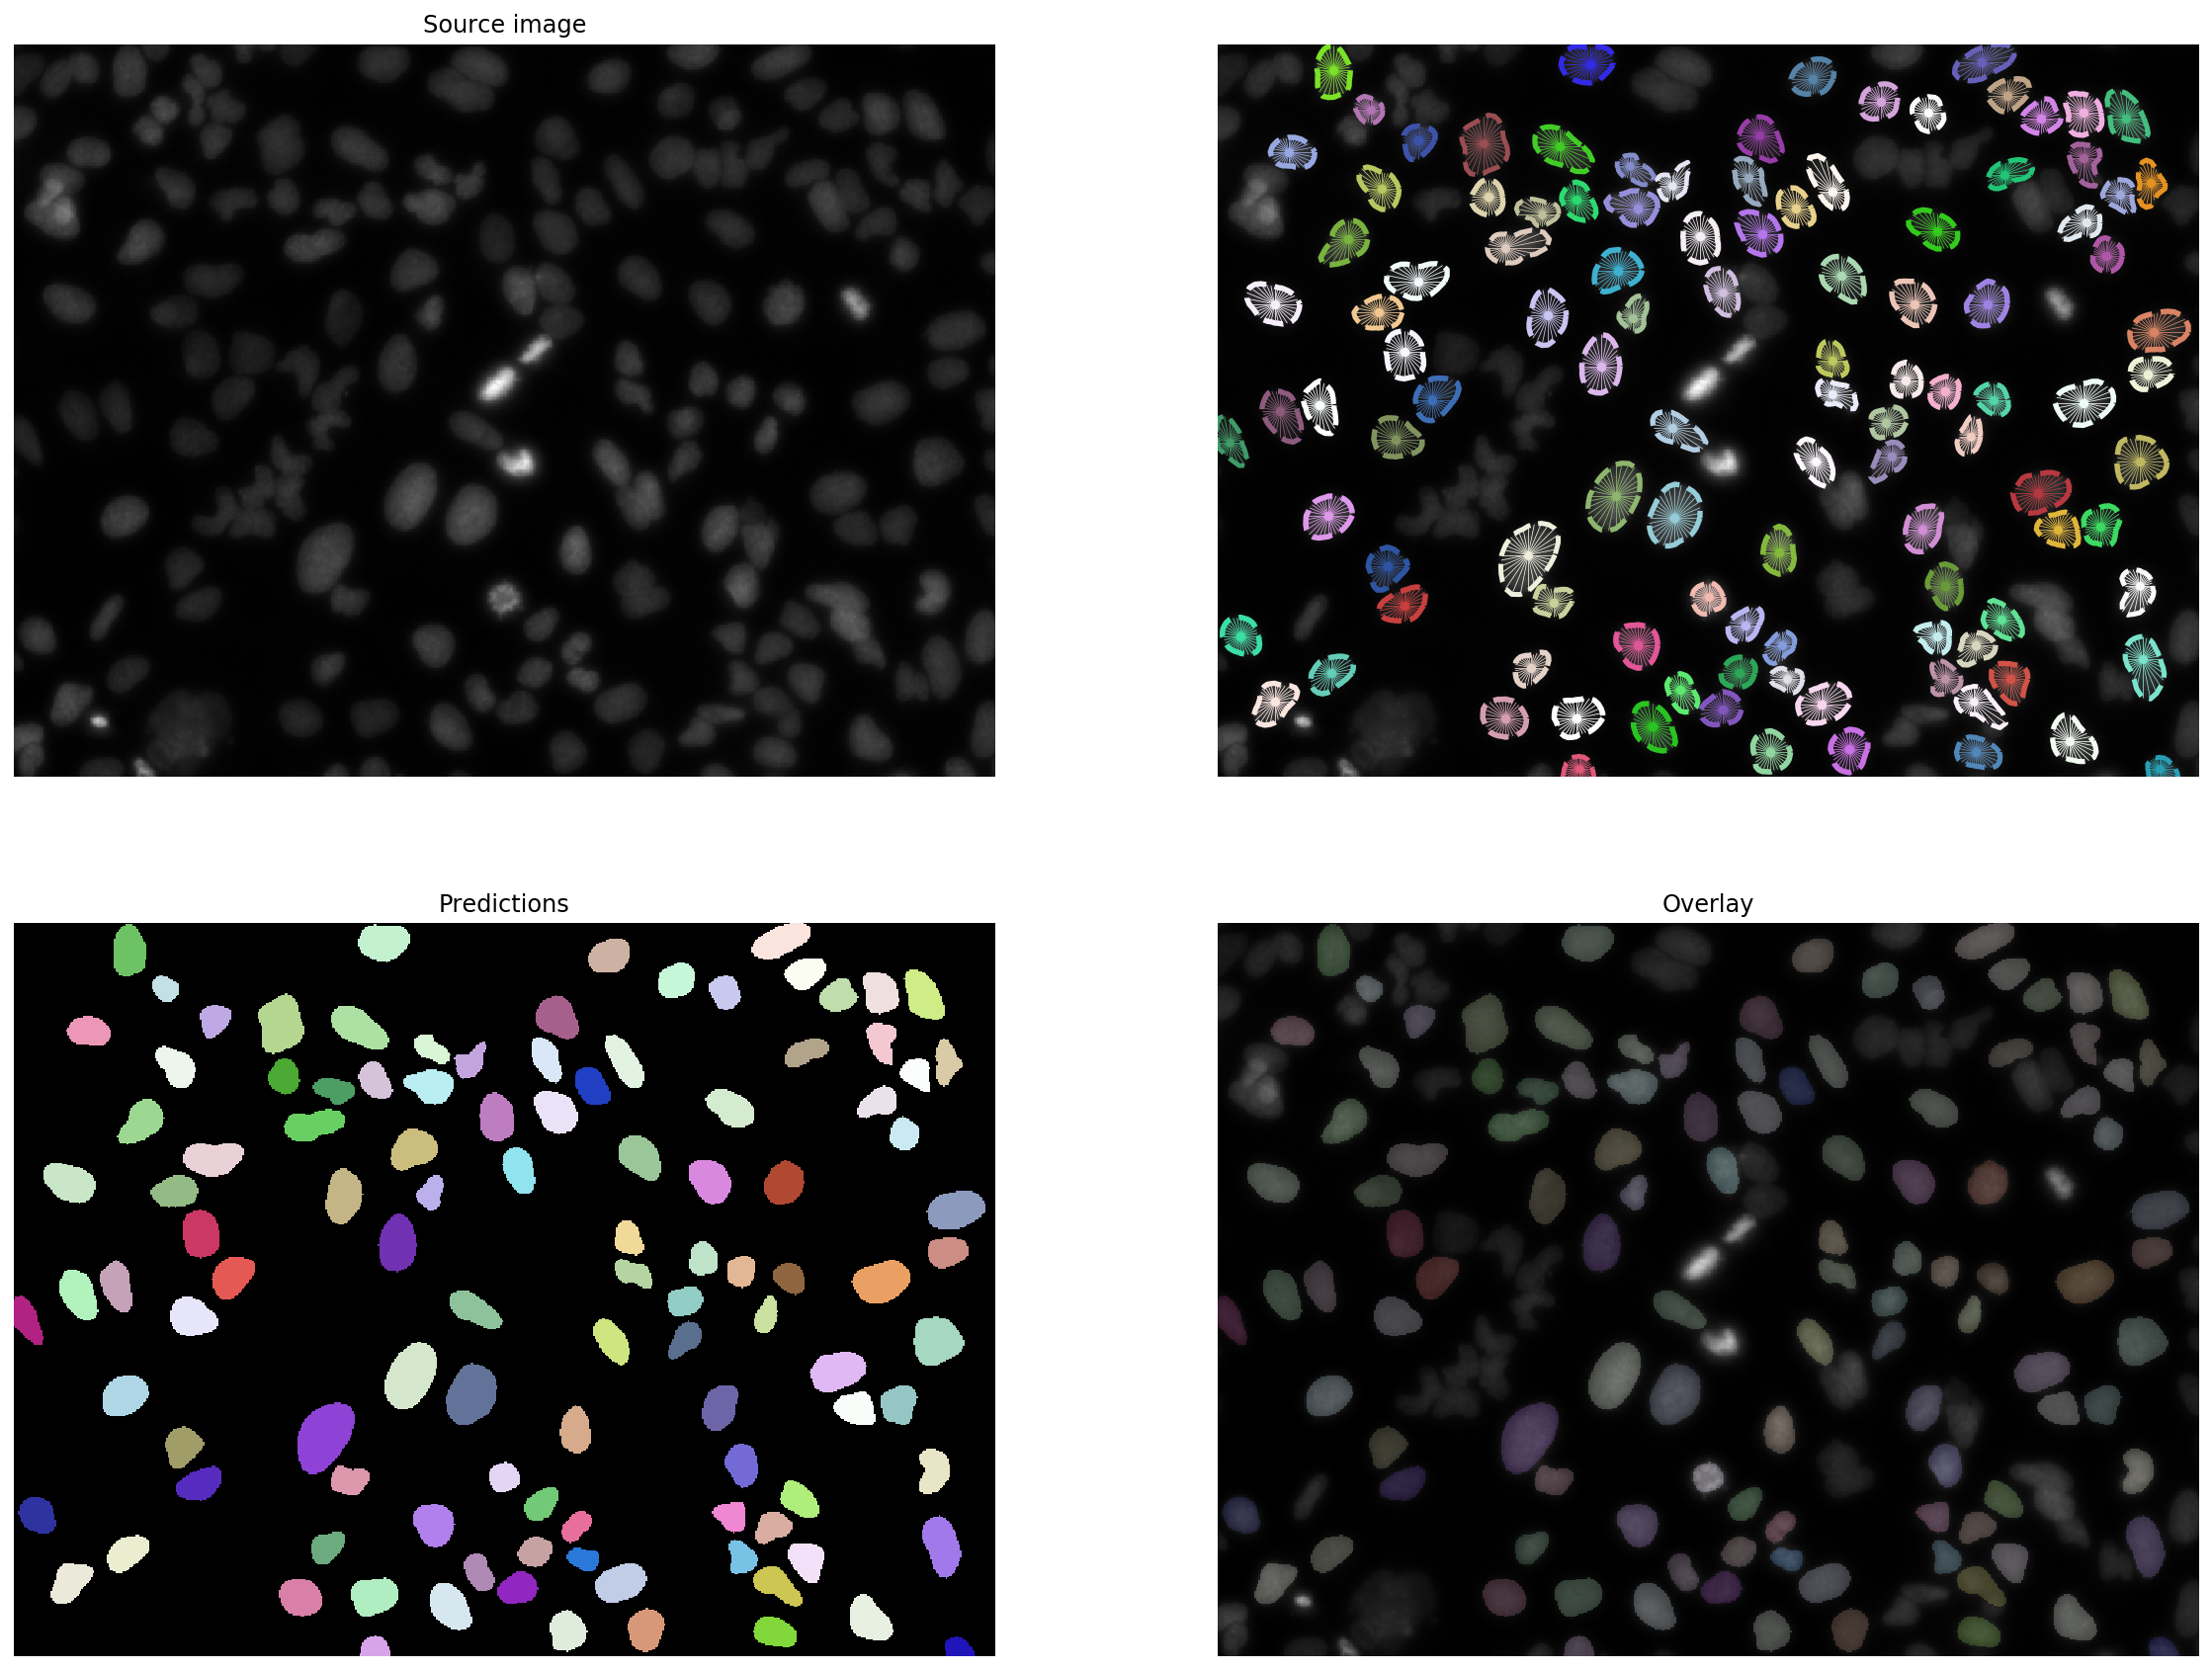

In [12]:
# Displaying the first image as example
plt.figure(figsize=(20,15))
plt.subplot(2,2,1); plt.imshow(X[0],cmap='gray', norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Source image')
plt.subplot(2,2,2);
img = X[0] if X[0].ndim==2 else X[0][...,0]
coord, points, prob = details[0]['coord'], details[0]['points'], details[0]['prob']
plt.imshow(img, cmap='gray'); plt.axis('off')
a = plt.axis()
_draw_polygons(coord, points, prob, show_dist=True)
plt.axis(a)

plt.subplot(2,2,3); plt.imshow(Labels[0],cmap=lbl_cmap, norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Predictions')
plt.subplot(2,2,4); plt.title('Overlay'); plt.axis('off');
plt.imshow(X[0] if X[0].ndim==2 else X[0][...,0], clim=(0,1), cmap='gray', norm=matplotlib.colors.Normalize())
plt.imshow(Labels[0], cmap=lbl_cmap, norm=matplotlib.colors.Normalize(), alpha=0.2)



In [40]:
# clearing memory
del predictions, details

NameError: name 'predictions' is not defined

# Segmentation

In [41]:
with mp.Pool() as pool:
    Labels = pool.map(im_ClearBorder,Labels)

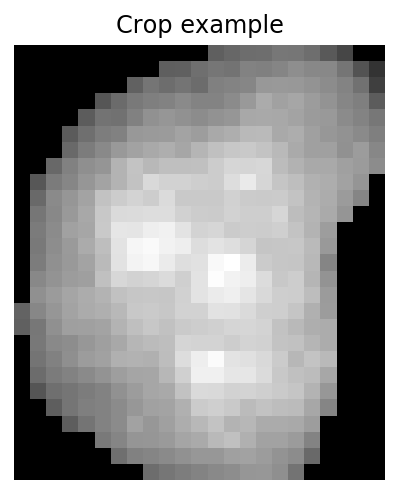

In [97]:
with mp.Pool() as pool:  
    Crops = pool.starmap(im_segment,zip(Labels,X))
    
if type(Crops[0])==np.ndarray:
    plt.imshow(Crops[0], cmap='gray', norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Crop example')
else:
    plt.imshow(Crops[0][0], cmap='gray', norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Crop example')
    

# Saving the segments

In [146]:
# Defining save_paths

assert len(Crops)==len(ImportDetails), 'Output is inconsistent with number of input files!'
save_paths = []
EmptyImgs=[]
EmptyIdx=[]
for I,single_source in enumerate(Crops):
    if type(single_source)!=type(None):
        source_info = ImportDetails[I]
        filename = source_info['File']
        field = filename[filename.find(source_info['Well'])+len(source_info['Well']):]
        field = field[:field.find('_')]
        save_paths.extend([os.path.abspath(os.path.join(SaveDir_of_SegmentedImg,f"{source_info['Plate']}{source_info['Well']}{field}_{i}_{source_info['Compound Name']}.tif")) for i in range(len(single_source))])
    else:
        EmptyIdx.append(I)
        source_info = ImportDetails[I]
        EmptyImgs.append(os.path.abspath(os.path.join(
            Local_ImgPath,
            str(source_info['Plate']+'-'+ChannelsOfInterest[0]),
            source_info['File']
        )))

Crops=np.delete(Crops,EmptyIdx)
ImportDetails=np.delete(ImportDetails,EmptyIdx)
        
print('No. of save paths = ',str(len(save_paths)))
print('1st save path :\n',save_paths[0])

print('\nNo. of empty images = ',str(len(EmptyImgs)))        
print('Empty paths :')
for path in EmptyImgs: print(path)

No. of save paths =  62531
1st save path :
 \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented\DMSO\25937_o11_s4_0_DMSO.tif

No. of empty images =  0
Empty paths :


In [ ]:
# saving the segments
NumOfFiles_ini = len(os.listdir(SaveDir_of_SegmentedImg))

crops = [crop for single_source in Crops for crop in single_source]
with mp.Pool() as pool:
    pool.starmap(cv2.imwrite,zip(save_paths,crops))

NumOfFiles_fin = len(os.listdir(SaveDir_of_SegmentedImg))
print('No. of files saved = ',str(NumOfFiles_fin-NumOfFiles_ini))